In [141]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import gmean, rankdata
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold

## Ансамблирование моделей

Ансамбль методов в статистике и машинном обучении использует несколько обучающих алгоритмов с целью получения лучшей эффективности прогнозирования, чем могли бы получить от каждого обучающего алгоритма по отдельности. Так что же такое ансамблирование? Под эти термином мы подразумеваем объединение множества различных моделей машинного обучения для получения более точного прогноза. Существуют различные ансамблевые методы, многие их которых регулярно используются в соревнованиях по машинному обучению, и как правило, оказываются достаточно конкурентноспособными. Мы начнем с простых методов усреднения, затем перейдем к методам взвешенного усреднения. А затем мы перейдем к более типичным методам, таким как бэггинг или очень популярная технология, стэкинга.

__Основная идея__ - использовать модели, близкие по качеству, но отличающиеся по природе / выборке, на которой обучались / степени регуляризации / подходу к созданию признаков / подходу к обработке категорий / ..., для взаимной компенсации ошибок друг друга и улучшения качества итоговой композиции.

* __Бэггинг__ - мы хотим подобрать несколько независимых моделей и усреднить их прогнозы, чтобы получить модель с меньшей дисперсией. На практике, мы не можем подобрать полностью независимые модели, потому что для этого требуется слишком много данных, а нащ датасет является ограниченным. Таким образом, мы должны снизить корреляции между моделями, в надежде снизить общую дисперсию. Можем использовать бутстрап выборки для создания независимых моделей, после чего "усреднить" прогнозы всех моделей.

* __Арифмитическое среднее__ - усреднее прогнозов моделей, похожих по значению метрики качества, не коррелированных друг с другом. Выделяют также взвешенное усреднее - веса подбираются вручную или с использованием scipy.optimize.

* __Стэкинг__ - использование прогнозов базовых моделей в качестве признаков или в дополнении к основным признакам, и обучение модели второго уровня на такой матрице признаков. Корреляция = 0.98, качество отдельных моделей - близко, модели / признаки / гиперпараметры как можно более разные.

In [96]:
data = pd.read_csv("data/porto_train.csv")
test = pd.read_csv("data/porto_lb.csv")
print("data.shape = {} rows, {} cols".format(*data.shape))

data.shape = 249988 rows, 59 cols


In [128]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=5000,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=10,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

In [98]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 750,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

cv = KFold(n_splits=7, random_state=435, shuffle=True)
target, data = data["target"], data.drop(["id", "target"], axis=1)

## BaseModel

In [27]:
estimators, oof_preds = lightgbm_cross_validation(
    lgbm_params, data, target, cv
)

Wed Dec  9 17:55:22 2020, Cross-Validation, 249988 rows, 57 cols
Training until validation scores don't improve for 5000 rounds
[50]	valid_0's auc: 0.634365	valid_0's binary_logloss: 0.156993
[100]	valid_0's auc: 0.636966	valid_0's binary_logloss: 0.156098
[150]	valid_0's auc: 0.638626	valid_0's binary_logloss: 0.15546
[200]	valid_0's auc: 0.640291	valid_0's binary_logloss: 0.155
[250]	valid_0's auc: 0.64068	valid_0's binary_logloss: 0.154674
[300]	valid_0's auc: 0.641156	valid_0's binary_logloss: 0.154429
[350]	valid_0's auc: 0.64175	valid_0's binary_logloss: 0.154229
[400]	valid_0's auc: 0.642155	valid_0's binary_logloss: 0.154079
[450]	valid_0's auc: 0.642472	valid_0's binary_logloss: 0.153958
[500]	valid_0's auc: 0.642892	valid_0's binary_logloss: 0.153857
[550]	valid_0's auc: 0.643239	valid_0's binary_logloss: 0.153777
[600]	valid_0's auc: 0.643623	valid_0's binary_logloss: 0.153714
[650]	valid_0's auc: 0.643896	valid_0's binary_logloss: 0.153675
[700]	valid_0's auc: 0.644307	vali

Fold 7, Valid score = 0.63207
Score by each fold: [0.64443, 0.63248, 0.63883, 0.63241, 0.63572, 0.63747, 0.63207]


In [28]:
score = roc_auc_score(target, oof_preds)
print(f"Score = {round(score, 4)}")

Score = 0.6361


## BaseModel + OneHotEncoding

In [99]:
categorical = [col for col in data.columns if col.endswith("_cat")]

train = pd.concat([data, test], axis=0).reset_index(drop=True)
train = pd.get_dummies(train, columns=categorical)

data_ohe = train.loc[:data.shape[0]-1]
test_ohe = train.loc[data.shape[0]:]

/Users/a17582007/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
estimators_with_ohe, oof_preds_with_ohe = lightgbm_cross_validation(
    lgbm_params, data_ohe, target, cv
)

Wed Dec  9 17:59:22 2020, Cross-Validation, 249988 rows, 227 cols
Training until validation scores don't improve for 5000 rounds
[50]	valid_0's auc: 0.639106	valid_0's binary_logloss: 0.156909
[100]	valid_0's auc: 0.640132	valid_0's binary_logloss: 0.156028
[150]	valid_0's auc: 0.639905	valid_0's binary_logloss: 0.155421
[200]	valid_0's auc: 0.640499	valid_0's binary_logloss: 0.154948
[250]	valid_0's auc: 0.641392	valid_0's binary_logloss: 0.154618
[300]	valid_0's auc: 0.641504	valid_0's binary_logloss: 0.154385
[350]	valid_0's auc: 0.641806	valid_0's binary_logloss: 0.154198
[400]	valid_0's auc: 0.641926	valid_0's binary_logloss: 0.154065
[450]	valid_0's auc: 0.642098	valid_0's binary_logloss: 0.153969
[500]	valid_0's auc: 0.642033	valid_0's binary_logloss: 0.153892
[550]	valid_0's auc: 0.642306	valid_0's binary_logloss: 0.153826
[600]	valid_0's auc: 0.642395	valid_0's binary_logloss: 0.153773
[650]	valid_0's auc: 0.642599	valid_0's binary_logloss: 0.153727
[700]	valid_0's auc: 0.6427

Fold 7, Valid score = 0.6311
Score by each fold: [0.64322, 0.63259, 0.64274, 0.63417, 0.63772, 0.63665, 0.6311]


In [38]:
score = roc_auc_score(target, oof_preds_with_ohe)
print(f"Score = {round(score, 4)}")

Score = 0.6368


## BaseModel + LightGBM-encoder

In [54]:
estimators_cat, oof_preds_cat = lightgbm_cross_validation(
    lgbm_params, data, target, cv, categorical=categorical
)

Wed Dec  9 18:06:18 2020, Cross-Validation, 249988 rows, 57 cols


/Users/a17582007/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/a17582007/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 5000 rounds
[50]	valid_0's auc: 0.63492	valid_0's binary_logloss: 0.156991
[100]	valid_0's auc: 0.636692	valid_0's binary_logloss: 0.156087
[150]	valid_0's auc: 0.63792	valid_0's binary_logloss: 0.155481
[200]	valid_0's auc: 0.638059	valid_0's binary_logloss: 0.155077
[250]	valid_0's auc: 0.638099	valid_0's binary_logloss: 0.154785
[300]	valid_0's auc: 0.638624	valid_0's binary_logloss: 0.154544
[350]	valid_0's auc: 0.638779	valid_0's binary_logloss: 0.154365
[400]	valid_0's auc: 0.639127	valid_0's binary_logloss: 0.154229
[450]	valid_0's auc: 0.639046	valid_0's binary_logloss: 0.154143
[500]	valid_0's auc: 0.639272	valid_0's binary_logloss: 0.154065
[550]	valid_0's auc: 0.639236	valid_0's binary_logloss: 0.15401
[600]	valid_0's auc: 0.63927	valid_0's binary_logloss: 0.153977
[650]	valid_0's auc: 0.639509	valid_0's binary_logloss: 0.153934
[700]	valid_0's auc: 0.63992	valid_0's binary_logloss: 0.153885
[750]	valid_0's auc: 0.63977	vali

/Users/a17582007/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/a17582007/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 5000 rounds
[50]	valid_0's auc: 0.621173	valid_0's binary_logloss: 0.148998
[100]	valid_0's auc: 0.622781	valid_0's binary_logloss: 0.148219
[150]	valid_0's auc: 0.623561	valid_0's binary_logloss: 0.14771
[200]	valid_0's auc: 0.623811	valid_0's binary_logloss: 0.147352
[250]	valid_0's auc: 0.623635	valid_0's binary_logloss: 0.14711
[300]	valid_0's auc: 0.62353	valid_0's binary_logloss: 0.14694
[350]	valid_0's auc: 0.624079	valid_0's binary_logloss: 0.146771
[400]	valid_0's auc: 0.624421	valid_0's binary_logloss: 0.146651
[450]	valid_0's auc: 0.624465	valid_0's binary_logloss: 0.146578
[500]	valid_0's auc: 0.625214	valid_0's binary_logloss: 0.146491
[550]	valid_0's auc: 0.625465	valid_0's binary_logloss: 0.14644
[600]	valid_0's auc: 0.625682	valid_0's binary_logloss: 0.146404
[650]	valid_0's auc: 0.626017	valid_0's binary_logloss: 0.146367
[700]	valid_0's auc: 0.626278	valid_0's binary_logloss: 0.146344
[750]	valid_0's auc: 0.626322	val

/Users/a17582007/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/a17582007/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 5000 rounds
[50]	valid_0's auc: 0.627829	valid_0's binary_logloss: 0.1594
[100]	valid_0's auc: 0.629251	valid_0's binary_logloss: 0.158505
[150]	valid_0's auc: 0.630946	valid_0's binary_logloss: 0.157891
[200]	valid_0's auc: 0.631373	valid_0's binary_logloss: 0.157488
[250]	valid_0's auc: 0.631638	valid_0's binary_logloss: 0.157188
[300]	valid_0's auc: 0.631762	valid_0's binary_logloss: 0.156964
[350]	valid_0's auc: 0.632224	valid_0's binary_logloss: 0.156796
[400]	valid_0's auc: 0.63294	valid_0's binary_logloss: 0.156658
[450]	valid_0's auc: 0.633286	valid_0's binary_logloss: 0.156565
[500]	valid_0's auc: 0.633915	valid_0's binary_logloss: 0.156479
[550]	valid_0's auc: 0.634432	valid_0's binary_logloss: 0.156414
[600]	valid_0's auc: 0.63479	valid_0's binary_logloss: 0.156371
[650]	valid_0's auc: 0.635251	valid_0's binary_logloss: 0.156331
[700]	valid_0's auc: 0.635563	valid_0's binary_logloss: 0.156307
[750]	valid_0's auc: 0.635631	va

/Users/a17582007/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/a17582007/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 5000 rounds
[50]	valid_0's auc: 0.625698	valid_0's binary_logloss: 0.154138
[100]	valid_0's auc: 0.627746	valid_0's binary_logloss: 0.153288
[150]	valid_0's auc: 0.628704	valid_0's binary_logloss: 0.152733
[200]	valid_0's auc: 0.629538	valid_0's binary_logloss: 0.152331
[250]	valid_0's auc: 0.629712	valid_0's binary_logloss: 0.152056
[300]	valid_0's auc: 0.629584	valid_0's binary_logloss: 0.151877
[350]	valid_0's auc: 0.630046	valid_0's binary_logloss: 0.151722
[400]	valid_0's auc: 0.63132	valid_0's binary_logloss: 0.151573
[450]	valid_0's auc: 0.631516	valid_0's binary_logloss: 0.151494
[500]	valid_0's auc: 0.631853	valid_0's binary_logloss: 0.15144
[550]	valid_0's auc: 0.632574	valid_0's binary_logloss: 0.151375
[600]	valid_0's auc: 0.632377	valid_0's binary_logloss: 0.151364
[650]	valid_0's auc: 0.632934	valid_0's binary_logloss: 0.151317
[700]	valid_0's auc: 0.632915	valid_0's binary_logloss: 0.151308
[750]	valid_0's auc: 0.632627	

/Users/a17582007/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/a17582007/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 5000 rounds
[50]	valid_0's auc: 0.631445	valid_0's binary_logloss: 0.161985
[100]	valid_0's auc: 0.632263	valid_0's binary_logloss: 0.161035
[150]	valid_0's auc: 0.633499	valid_0's binary_logloss: 0.160375
[200]	valid_0's auc: 0.6346	valid_0's binary_logloss: 0.159893
[250]	valid_0's auc: 0.634905	valid_0's binary_logloss: 0.159558
[300]	valid_0's auc: 0.635325	valid_0's binary_logloss: 0.15931
[350]	valid_0's auc: 0.635373	valid_0's binary_logloss: 0.159137
[400]	valid_0's auc: 0.635993	valid_0's binary_logloss: 0.158985
[450]	valid_0's auc: 0.63587	valid_0's binary_logloss: 0.158897
[500]	valid_0's auc: 0.636242	valid_0's binary_logloss: 0.158816
[550]	valid_0's auc: 0.636533	valid_0's binary_logloss: 0.158758
[600]	valid_0's auc: 0.636518	valid_0's binary_logloss: 0.158731
[650]	valid_0's auc: 0.63678	valid_0's binary_logloss: 0.158691
[700]	valid_0's auc: 0.637135	valid_0's binary_logloss: 0.158649
[750]	valid_0's auc: 0.637367	val

/Users/a17582007/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/a17582007/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 5000 rounds
[50]	valid_0's auc: 0.629009	valid_0's binary_logloss: 0.15124
[100]	valid_0's auc: 0.627257	valid_0's binary_logloss: 0.150405
[150]	valid_0's auc: 0.628232	valid_0's binary_logloss: 0.149827
[200]	valid_0's auc: 0.628763	valid_0's binary_logloss: 0.149417
[250]	valid_0's auc: 0.629149	valid_0's binary_logloss: 0.14913
[300]	valid_0's auc: 0.629381	valid_0's binary_logloss: 0.148921
[350]	valid_0's auc: 0.629729	valid_0's binary_logloss: 0.148766
[400]	valid_0's auc: 0.630156	valid_0's binary_logloss: 0.148642
[450]	valid_0's auc: 0.629898	valid_0's binary_logloss: 0.148575
[500]	valid_0's auc: 0.629929	valid_0's binary_logloss: 0.148508
[550]	valid_0's auc: 0.630343	valid_0's binary_logloss: 0.148445
[600]	valid_0's auc: 0.63035	valid_0's binary_logloss: 0.14841
[650]	valid_0's auc: 0.630343	valid_0's binary_logloss: 0.148386
[700]	valid_0's auc: 0.630515	valid_0's binary_logloss: 0.148355
[750]	valid_0's auc: 0.630371	va

/Users/a17582007/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/a17582007/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 5000 rounds
[50]	valid_0's auc: 0.620985	valid_0's binary_logloss: 0.152677
[100]	valid_0's auc: 0.621309	valid_0's binary_logloss: 0.151936
[150]	valid_0's auc: 0.622807	valid_0's binary_logloss: 0.15143
[200]	valid_0's auc: 0.623426	valid_0's binary_logloss: 0.151077
[250]	valid_0's auc: 0.623584	valid_0's binary_logloss: 0.150852
[300]	valid_0's auc: 0.624011	valid_0's binary_logloss: 0.150675
[350]	valid_0's auc: 0.624321	valid_0's binary_logloss: 0.150554
[400]	valid_0's auc: 0.624793	valid_0's binary_logloss: 0.15047
[450]	valid_0's auc: 0.624771	valid_0's binary_logloss: 0.15042
[500]	valid_0's auc: 0.625273	valid_0's binary_logloss: 0.150371
[550]	valid_0's auc: 0.625733	valid_0's binary_logloss: 0.150332
[600]	valid_0's auc: 0.625832	valid_0's binary_logloss: 0.150319
[650]	valid_0's auc: 0.625902	valid_0's binary_logloss: 0.150309
[700]	valid_0's auc: 0.625888	valid_0's binary_logloss: 0.150307
[750]	valid_0's auc: 0.625722	v

In [55]:
score = roc_auc_score(target, oof_preds_cat)
print(f"Score = {round(score, 4)}")

Score = 0.6327


## LightGBM with permutation

In [79]:
to_drop = [
    'ps_calc_16_bin',
    'ps_calc_15_bin',
    'ps_ind_10_bin',
    'ps_ind_11_bin',
    'ps_calc_01',
    'ps_calc_11',
    'ps_ind_13_bin',
    'ps_ind_18_bin',
    'ps_ind_14',
    'ps_car_10_cat',
    'ps_calc_19_bin',
    'ps_calc_20_bin',
    'ps_calc_06',
    'ps_calc_09',
    'ps_car_05_cat',
    'ps_calc_12',
    'ps_car_06_cat',
    'ps_calc_08'
]

In [80]:
estimators_perm, oof_preds_perm = lightgbm_cross_validation(
    lgbm_params, data.drop(to_drop, axis=1), target, cv
)

Wed Dec  9 18:15:19 2020, Cross-Validation, 249988 rows, 39 cols
Training until validation scores don't improve for 5000 rounds
[50]	valid_0's auc: 0.638517	valid_0's binary_logloss: 0.156958
[100]	valid_0's auc: 0.63959	valid_0's binary_logloss: 0.15605
[150]	valid_0's auc: 0.640105	valid_0's binary_logloss: 0.155408
[200]	valid_0's auc: 0.640827	valid_0's binary_logloss: 0.154937
[250]	valid_0's auc: 0.641112	valid_0's binary_logloss: 0.15461
[300]	valid_0's auc: 0.642307	valid_0's binary_logloss: 0.154336
[350]	valid_0's auc: 0.642986	valid_0's binary_logloss: 0.154132
[400]	valid_0's auc: 0.643381	valid_0's binary_logloss: 0.15398
[450]	valid_0's auc: 0.643189	valid_0's binary_logloss: 0.153887
[500]	valid_0's auc: 0.643439	valid_0's binary_logloss: 0.153796
[550]	valid_0's auc: 0.643806	valid_0's binary_logloss: 0.153717
[600]	valid_0's auc: 0.644339	valid_0's binary_logloss: 0.153645
[650]	valid_0's auc: 0.644821	valid_0's binary_logloss: 0.15358
[700]	valid_0's auc: 0.64505	vali

Fold 7, Valid score = 0.63257
Score by each fold: [0.64537, 0.63414, 0.64008, 0.63448, 0.63713, 0.63731, 0.63257]


In [81]:
score = roc_auc_score(target, oof_preds_perm)
print(f"Score = {round(score, 4)}")

Score = 0.6372


## LightGBM with different hyperparams

In [121]:
params = {
    'boosting_type': 'goss',
    'n_estimators': 750,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

In [123]:
estimators_goss, oof_preds_goss = lightgbm_cross_validation(
    params, data, target, cv
)

Wed Dec  9 18:44:38 2020, Cross-Validation, 249988 rows, 57 cols
Training until validation scores don't improve for 5000 rounds
[50]	valid_0's auc: 0.634365	valid_0's binary_logloss: 0.156993
[100]	valid_0's auc: 0.636966	valid_0's binary_logloss: 0.156098
[150]	valid_0's auc: 0.638626	valid_0's binary_logloss: 0.15546
[200]	valid_0's auc: 0.640071	valid_0's binary_logloss: 0.155008
[250]	valid_0's auc: 0.64096	valid_0's binary_logloss: 0.154666
[300]	valid_0's auc: 0.641773	valid_0's binary_logloss: 0.154402
[350]	valid_0's auc: 0.642189	valid_0's binary_logloss: 0.154206
[400]	valid_0's auc: 0.64289	valid_0's binary_logloss: 0.154034
[450]	valid_0's auc: 0.643298	valid_0's binary_logloss: 0.153908
[500]	valid_0's auc: 0.643482	valid_0's binary_logloss: 0.153817
[550]	valid_0's auc: 0.643855	valid_0's binary_logloss: 0.153738
[600]	valid_0's auc: 0.644195	valid_0's binary_logloss: 0.153669
[650]	valid_0's auc: 0.644352	valid_0's binary_logloss: 0.153629
[700]	valid_0's auc: 0.644794	v

Fold 7, Valid score = 0.63063
Score by each fold: [0.64484, 0.63298, 0.63936, 0.6324, 0.63598, 0.63665, 0.63063]


In [125]:
score = roc_auc_score(target, oof_preds_goss)
print(f"Score = {round(score, 4)}")

Score = 0.6359


## XGBoost

In [137]:
xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.05",
    "max_depth": 6,
    "gamma": 10,
    "subsample": 0.85,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 30,
    "alpha": 0,
    "lambda": 0,
    "nthread": 6,
    "random_seed": 42
}

xgb_cv = KFold(n_splits=10, random_state=42, shuffle=True)

In [138]:
xgb_estimators, _, xgb_oof = xgboost_cross_validation(
    xgb_params, data, target, xgb_cv
)

Wed Dec  9 21:09:16 2020, Cross-Validation, 249988 rows, 57 cols


/Users/a17582007/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.587197	valid-auc:0.575258
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.61583	valid-auc:0.601419
[20]	train-auc:0.620423	valid-auc:0.607197
[30]	train-auc:0.623124	valid-auc:0.60973
[40]	train-auc:0.626986	valid-auc:0.612121
[50]	train-auc:0.632583	valid-auc:0.615119
[60]	train-auc:0.637558	valid-auc:0.620324
[70]	train-auc:0.642669	valid-auc:0.623182
[80]	train-auc:0.645558	valid-auc:0.625111
[90]	train-auc:0.649073	valid-auc:0.627375
[100]	train-auc:0.651409	valid-auc:0.628736
[110]	train-auc:0.653259	valid-auc:0.629615
[120]	train-auc:0.655039	valid-auc:0.630382
[130]	train-auc:0.65679	valid-auc:0.630537
[140]	train-auc:0.658509	valid-auc:0.630859
[150]	train-auc:0.660582	valid-auc:0.631355
[160]	train-auc:0.661681	valid-auc:0.631956
[170]	train-auc:0.662309	valid-auc:0.632213
[180]	train-auc:0.663489	valid-auc:0.631999
[190]	train-auc:0.664384	valid-auc:

/Users/a17582007/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.584204	valid-auc:0.575628
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.6186	valid-auc:0.604766
[20]	train-auc:0.622638	valid-auc:0.603455
[30]	train-auc:0.625474	valid-auc:0.606841
[40]	train-auc:0.628745	valid-auc:0.606563
[50]	train-auc:0.633002	valid-auc:0.609721
[60]	train-auc:0.636841	valid-auc:0.612613
[70]	train-auc:0.642713	valid-auc:0.616435
[80]	train-auc:0.64583	valid-auc:0.618092
[90]	train-auc:0.649488	valid-auc:0.621528
[100]	train-auc:0.651796	valid-auc:0.622842
[110]	train-auc:0.65328	valid-auc:0.62363
[120]	train-auc:0.655359	valid-auc:0.624279
[130]	train-auc:0.656989	valid-auc:0.625221
[140]	train-auc:0.658854	valid-auc:0.625489
[150]	train-auc:0.66036	valid-auc:0.626192
[160]	train-auc:0.661691	valid-auc:0.626834
[170]	train-auc:0.662888	valid-auc:0.626707
[180]	train-auc:0.664484	valid-auc:0.626288
Stopping. Best iteration:
[161]	train-

/Users/a17582007/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.583011	valid-auc:0.586038
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.612934	valid-auc:0.614104
[20]	train-auc:0.619998	valid-auc:0.617962
[30]	train-auc:0.623778	valid-auc:0.619746
[40]	train-auc:0.626126	valid-auc:0.622788
[50]	train-auc:0.630426	valid-auc:0.625297
[60]	train-auc:0.636175	valid-auc:0.630331
[70]	train-auc:0.64068	valid-auc:0.633929
[80]	train-auc:0.644421	valid-auc:0.63545
[90]	train-auc:0.647979	valid-auc:0.637674
[100]	train-auc:0.650533	valid-auc:0.638271
[110]	train-auc:0.652566	valid-auc:0.638794
[120]	train-auc:0.654079	valid-auc:0.639773
[130]	train-auc:0.656012	valid-auc:0.640161
[140]	train-auc:0.657999	valid-auc:0.641359
[150]	train-auc:0.659451	valid-auc:0.641413
[160]	train-auc:0.660685	valid-auc:0.641506
[170]	train-auc:0.662322	valid-auc:0.641959
[180]	train-auc:0.663087	valid-auc:0.642419
[190]	train-auc:0.664449	valid-auc

/Users/a17582007/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.585364	valid-auc:0.567328
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.615434	valid-auc:0.600044
[20]	train-auc:0.620676	valid-auc:0.603059
[30]	train-auc:0.626288	valid-auc:0.60638
[40]	train-auc:0.629618	valid-auc:0.608013


KeyboardInterrupt: 

In [139]:
score = roc_auc_score(target, xgb_oof)
print(f"Score = {round(score, 4)}")

Score = 0.5975


## Prediction Correlation

In [126]:
scores = pd.DataFrame({
    "lgbm_numerical": oof_preds,
    "lgbm_categorical": oof_preds_cat,
    "lgbm_with_ohe": oof_preds_with_ohe,
    "lgbm_numerical_with_permutation": oof_preds_perm,
    "lgbm_goss_numerical": oof_preds_goss,
    "xgb_numerical": xgb_oof,
    
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

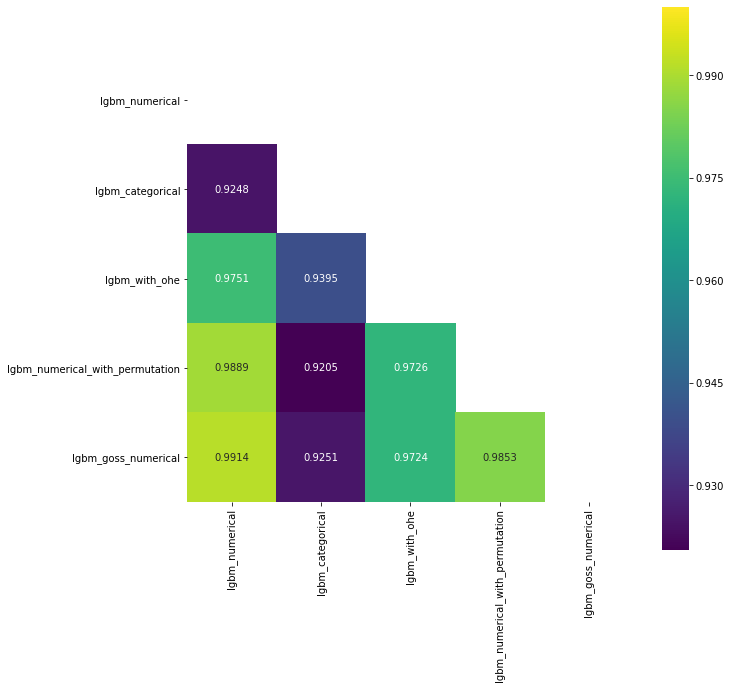

In [127]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

## AMean

In [115]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

# 0.6*best + 0.4*(best-1)
# scipy.optimize

Score = 0.6371


## GMean

In [140]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.6374


## Rankdata

In [149]:
# ROC-AUC / GINI
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.6375


In [150]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.6374


## Модель 2-го уровня: blending & stacking

In [ ]:
train -> x_train, x_valid

In [ ]:
1. x_train(feature_1, feature_2, ..., feature_m) -> fit model -> y_pred
2. x_train_oof_preds(y_pred_model1, y_pred_model2, ...) -> fit second level model

x_train-OOF
x_test-SUB

# LogisticRegression
# XGBoost / LightGBM <= 10-15
# Sequential Backward Selection

In [ ]:
OOF-predictions.csv
submit-predictions.csv

imbalanced-learning